# Problem Statement

## Context
BoomBikes, a US bike-sharing provider, aims to predict the demand for shared bikes post-Covid to boost revenue post-pandemic.
They have gathered a dataset on daily bike demands in the American market to understand the factors influencing bike demand.

## Goal
Model the bike demand using independent variables to adjust business strategies and meet customer expectations.

# Approach

Check if linear regression can be applied to model the `cnt` variable

**Approach for linear regression** -
1. **Data Preparation**
   - Collect and clean data: Handle missing values, duplicates, and outliers.
2. **Explore the data**
   - Visualize relationships between predictors and target variables using scatter plots, pair plots or correlation matrices
   - Perform Univariate, Bivariate and Multivariate analysis
3. **Build the model**
   - Feature selection: Choose relevant predictors. Transform features if necessary (e.g., scaling).
   - Split data: Divide the dataset into training and testing sets (e.g., 70%-30%).
   - Check assumptions:
     - Linearity between predictors and the target.
     - No multicollinearity among predictors.
   - Fit the model
   - Check coefficients
4. **Evaluate the model**
   - Performance metrics: Use metrics like:
       - R²: Measures variance explained by the model.
       - Adjusted R²: Adjusts R² for the number of predictors.
       - Mean Squared Error (MSE) or Root Mean Squared Error (RMSE).
   - Residual analysis:
       - Check residual plots for patterns.
       - Ensure residuals have constant variance and are normally distributed.
5. **Refine the Model**
   - Remove insignificant predictors: Simplify the model by dropping non-contributory features.
   - Check for overfitting: Ensure the model generalizes well to the test data.

# Solution

## Import Libraries

In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

In [2]:
import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Load Data

In [451]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Data Preparation

**Actions:**

1. `casual` and `registered` have a very strong positive correlation with cnt since cnt is their sum. Hence these should be removed.
2. Remove `dteday` because it does not help the cause
3. Map `yr` values to `0: 2018` and 1: 2019`
4. Convert `weathersit` and `season` into categorical variables

`weathersit`:
1: Clear
2: Mist
3: LightRain
4: HeavyRain

`season`:
1:spring, 2:summer, 3:fall, 4:winter

### Check for missing values

In [5]:
print(df.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


### Map `yr` values to `0: 2018` and `1: 2019`

In [452]:
df.yr.value_counts()

yr
0    365
1    365
Name: count, dtype: int64

In [453]:
mapping_yr = {0: 2018, 1: 2019}
df.yr = df.yr.map(mapping_yr)

In [454]:
df.yr.value_counts()

yr
2018    365
2019    365
Name: count, dtype: int64

### Convert `weathersit` and `season` into categorical variables

In [455]:
print(df.weathersit.value_counts())
print(df.season.value_counts())

weathersit
1    463
2    246
3     21
Name: count, dtype: int64
season
3    188
2    184
1    180
4    178
Name: count, dtype: int64


In [456]:
mapping_weathersit = {1: 'Clear', 2: 'Mist', 3: 'LightRain', 4: 'HeavyRain'}
mapping_season = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}

df.weathersit = df.weathersit.map(mapping_weathersit)
df.season = df.season.map(mapping_season)

In [457]:
df.weathersit.value_counts()

weathersit
Clear        463
Mist         246
LightRain     21
Name: count, dtype: int64

In [458]:
df.season.value_counts()

season
Fall      188
Summer    184
Spring    180
Winter    178
Name: count, dtype: int64

### Remove `instant`, `dteday`, `casual` and `registered` because they do not help the cause

`casual + registered = cnt` Hence there's a high collinearity between casual, registered and cnt. So, casual & registered can be removed. 

In [459]:
df = df.drop(['dteday', 'casual', 'registered', 'instant'], axis=1)

In [460]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,2018,1,0,6,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,Spring,2018,1,0,0,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,Spring,2018,1,0,1,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,2018,1,0,2,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,2018,1,0,3,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


## Exploratory Data Analysis

### Univariate Analysis

In [461]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 68.6+ KB


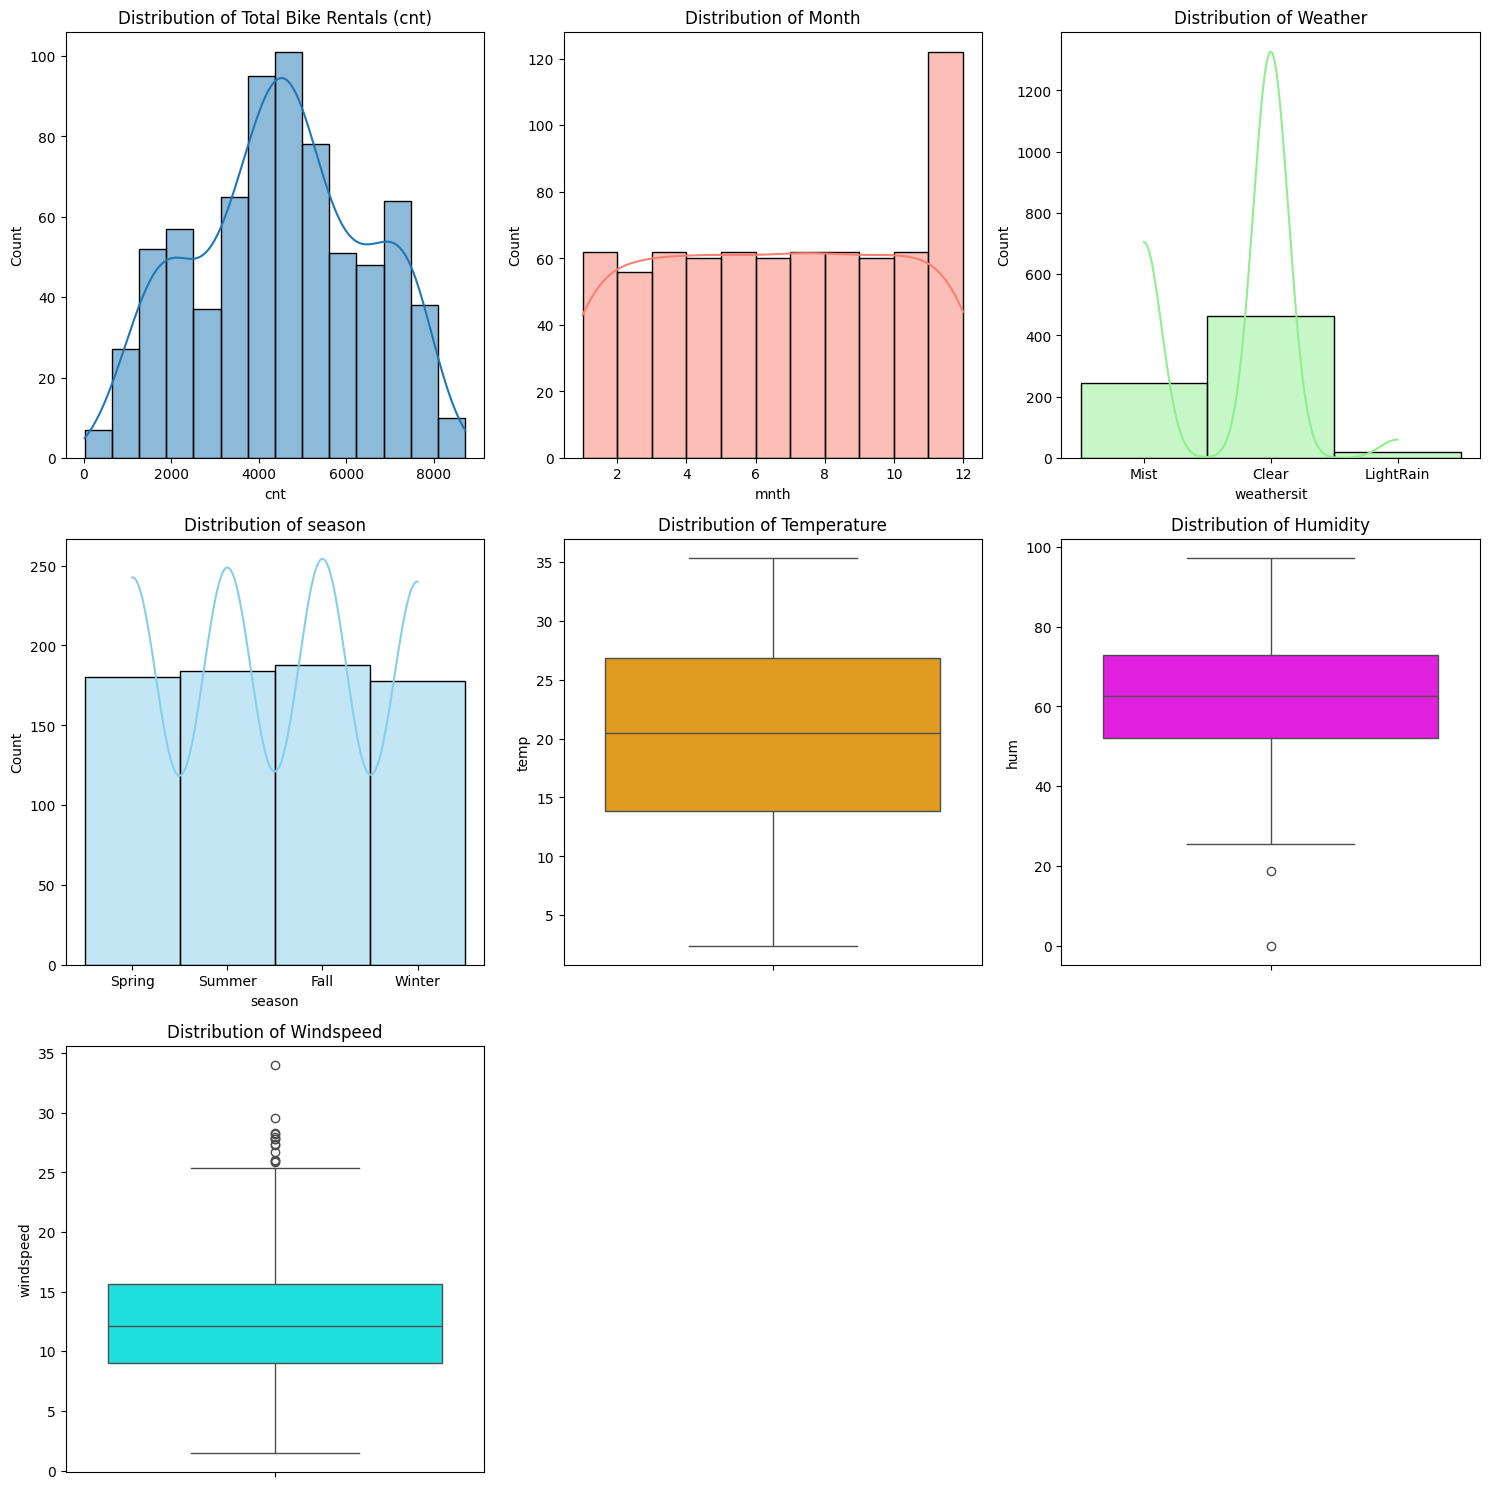

In [491]:
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 1)
sns.histplot(df.cnt, kde=True)
plt.title('Distribution of Total Bike Rentals (cnt)')

plt.subplot(3, 3, 2)
sns.histplot(df.mnth, kde=True, color='salmon', edgecolor='black')
plt.title('Distribution of Month')

plt.subplot(3, 3, 3)
sns.histplot(df.weathersit, kde=True, color='lightgreen', edgecolor='black')
plt.title('Distribution of Weather')

plt.subplot(3, 3, 4)
sns.histplot(df.season, kde=True, color="skyblue", edgecolor="black")
plt.title('Distribution of season')

plt.subplot(3, 3, 5)
sns.boxplot(df.temp, color="orange")
plt.title('Distribution of Temperature')

plt.subplot(3, 3, 6)
sns.boxplot(df.hum, color="magenta")
plt.title('Distribution of Humidity')

plt.subplot(3, 3, 7)
sns.boxplot(df.windspeed, color="aqua")
plt.title('Distribution of Windspeed')

plt.tight_layout()
plt.show()

**Insights**:
> 1. The distribution of cnt is slightly right skewed, it indicates that a few days have significantly higher rentals compared to others
> 2. The most frequently occurring weather is clear and mist
> 3. Median temp is 20 while that for the humidity is 60 and for windspeed is 12. Such weather conditions seem to be favourable for the season.

### Bivariate analysis

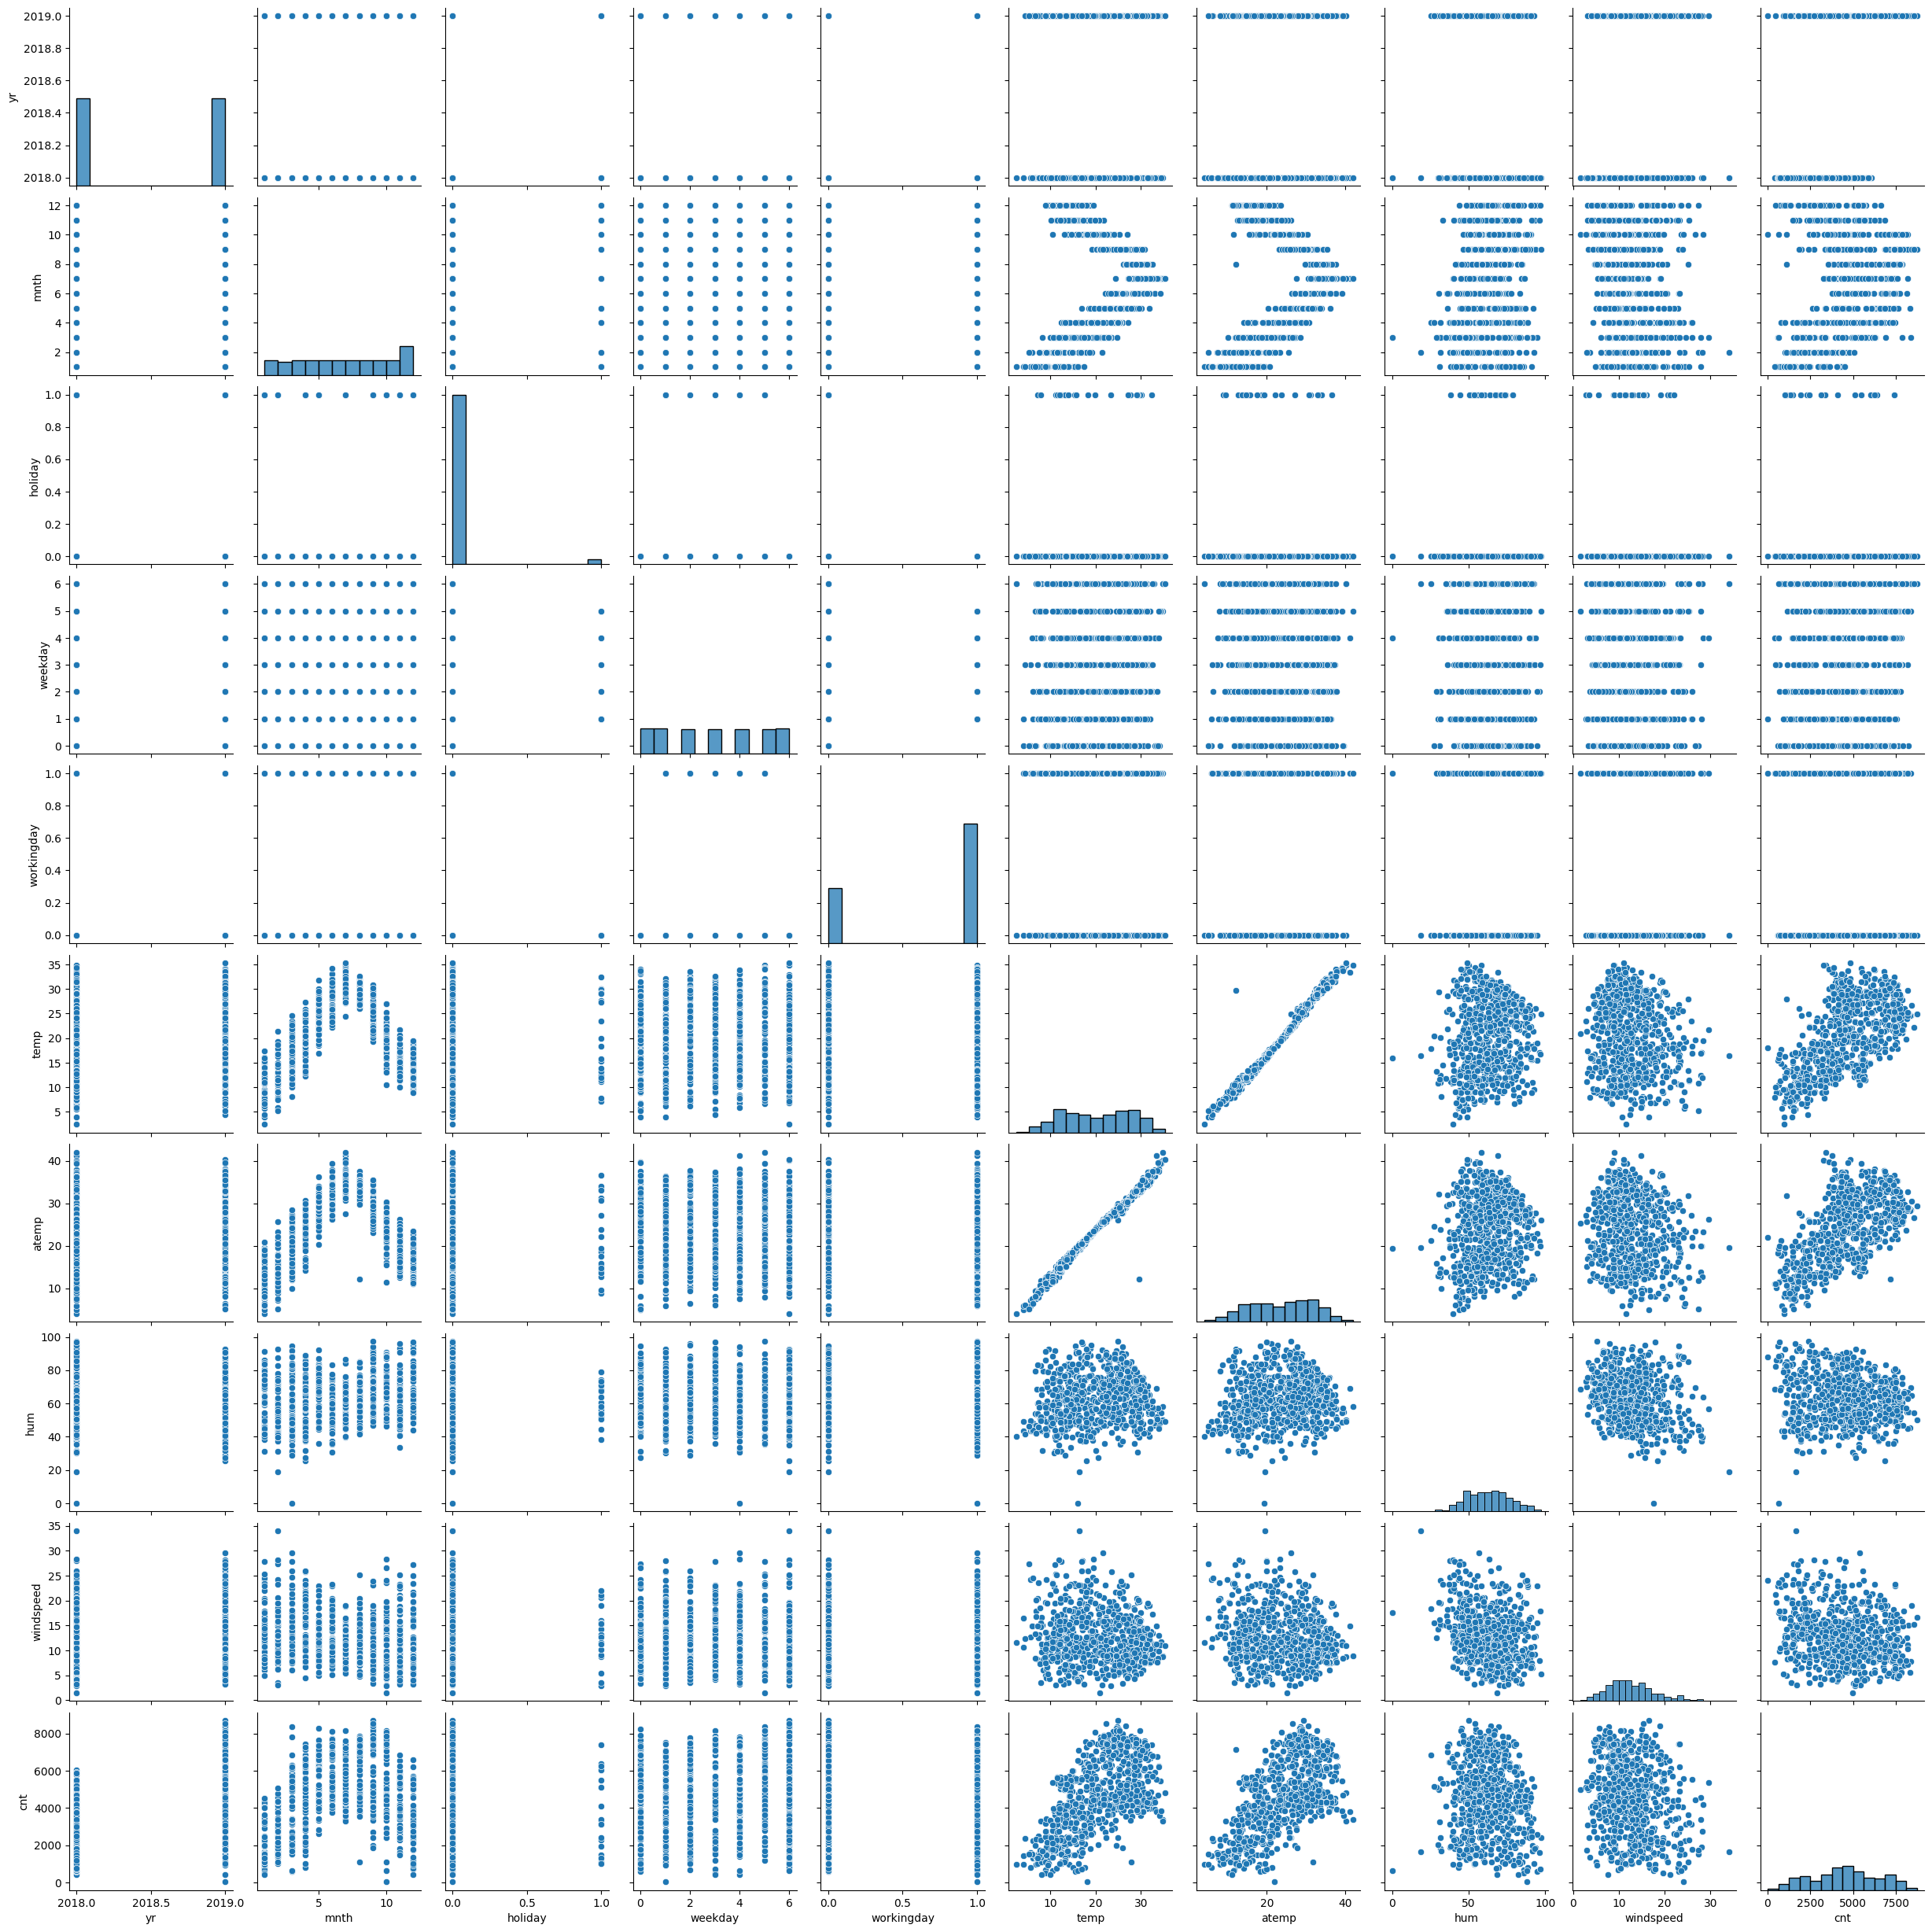

In [23]:
sns.pairplot(data=df)

**Insights**
> From this analysis, it seems that
> 1. The target variable `cnt` has a good linear relationship with `temp` and `atemp`.
> 2. The count of bike sharings has significantly increased in the year 2019.
> 3. The number of bike sharings is higher in the months from April to October.
> 4. The factors humidity (`hum`) and `windspeed` do not have linear correlation with the `cnt`

#### Visualizing Categorical Variables

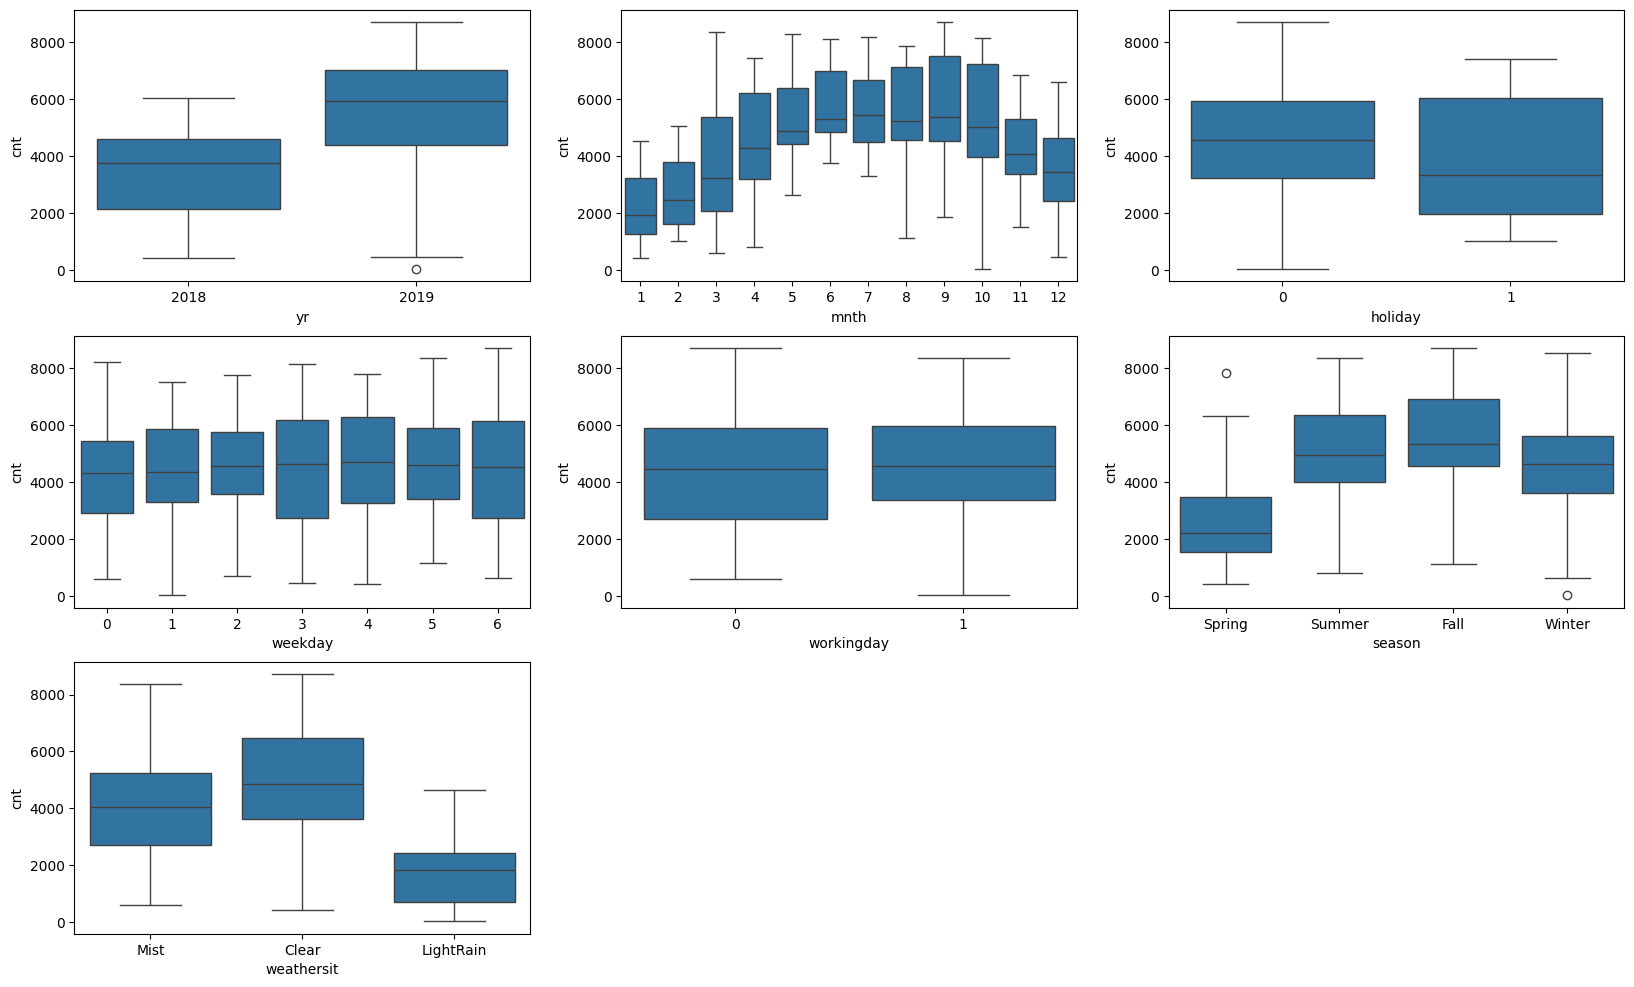

In [25]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'yr', y = 'cnt', data = df)
plt.subplot(3,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = df)
plt.subplot(3,3,3)
sns.boxplot(x = 'holiday', y = 'cnt', data = df)
plt.subplot(3,3,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = df)
plt.subplot(3,3,5)
sns.boxplot(x = 'workingday', y = 'cnt', data = df)
plt.subplot(3,3,6)
sns.boxplot(x = 'season', y = 'cnt', data = df)
plt.subplot(3,3,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df)
plt.show()


**Insights**
> From the above charts, `cnt` increases year over year, it is highest in the months of April to October, highest on non holidays, and high in Summer and fall, high in non rainy days.

### Multivariate Analysis

<Axes: >

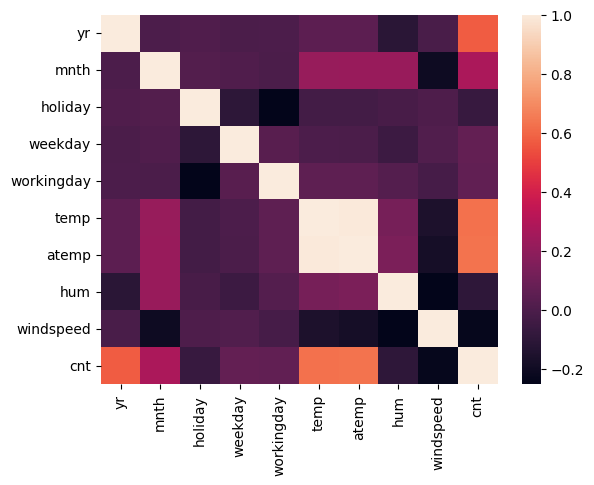

In [24]:
sns.heatmap(df[['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp',	'hum',	'windspeed', 'cnt']].corr())

**Insights**
> From the above heatmap, `cnt` has a high correlation with `yr`, `temp` & `atemp`

### Insights from EDA

1. Distribution of Total Bike Rentals (cnt):
The distribution is slightly right-skewed, indicating a higher frequency of lower rental counts.
3. Bike Rentals by Season:
Rentals vary significantly across seasons:
Fall seems to have the highest median rental count.
Spring has the lowest median rental count.
4. Bike Rentals by Weather Situation:
Rentals decrease as weather worsens:
Clear or Partly Cloudy weather corresponds to the highest rental counts.
Heavy Rain or Snow shows the lowest rental counts.

## Build the model

### Dummy Variables

We'll have to transform the categories of the categorical variables into dummy variables and concat them in the original dataset.

In [26]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 68.6+ KB


In [27]:
season = pd.get_dummies(df['season'], dtype='int')
weathersit = pd.get_dummies(df['weathersit'], dtype='int')

In [29]:
season

,Fall,Spring,Summer,Winter
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
725,0,1,0,0
726,0,1,0,0
727,0,1,0,0
728,0,1,0,0


In [30]:
df.weathersit.value_counts()

weathersit
Clear        463
Mist         246
LightRain     21
Name: count, dtype: int64

In [31]:
df = pd.concat([df, season, weathersit], axis = 1)

In [32]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,Fall,Spring,Summer,Winter,Clear,LightRain,Mist
0,Spring,2018,1,0,6,0,Mist,14.110847,18.18125,80.5833,10.749882,985,0,1,0,0,0,0,1
1,Spring,2018,1,0,0,0,Mist,14.902598,17.68695,69.6087,16.652113,801,0,1,0,0,0,0,1
2,Spring,2018,1,0,1,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,0,1,0,0,1,0,0
3,Spring,2018,1,0,2,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,0,1,0,0,1,0,0
4,Spring,2018,1,0,3,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,0,1,0,0,1,0,0


In [33]:
df = df.drop(columns=['season', 'weathersit'])
df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,Fall,Spring,Summer,Winter,Clear,LightRain,Mist
0,2018,1,0,6,0,14.110847,18.18125,80.5833,10.749882,985,0,1,0,0,0,0,1
1,2018,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,1,0,0,0,0,1
2,2018,1,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,1,0,0,1,0,0
3,2018,1,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,0,1,0,0,1,0,0
4,2018,1,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,0,1,0,0,1,0,0


### Feature Slection

The target variable is `cnt`. Let's choose all the other variables as predictors to start with and remove predictors as and when required.

### Split the data

In [34]:
y = df.cnt

In [35]:
df.shape

(730, 17)

In [36]:
X = df

In [37]:
X.pop('cnt')

0       985
1       801
2      1349
3      1562
4      1600
       ... 
725    2114
726    3095
727    1341
728    1796
729    2729
Name: cnt, Length: 730, dtype: int64

In [38]:
X.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,Fall,Spring,Summer,Winter,Clear,LightRain,Mist
0,2018,1,0,6,0,14.110847,18.18125,80.5833,10.749882,0,1,0,0,0,0,1
1,2018,1,0,0,0,14.902598,17.68695,69.6087,16.652113,0,1,0,0,0,0,1
2,2018,1,0,1,1,8.050924,9.47025,43.7273,16.636703,0,1,0,0,1,0,0
3,2018,1,0,2,1,8.200000,10.60610,59.0435,10.739832,0,1,0,0,1,0,0
4,2018,1,0,3,1,9.305237,11.46350,43.6957,12.522300,0,1,0,0,1,0,0


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [40]:
print(X_train.shape)
print(X_test.shape)

(510, 16)
(219, 16)


### Scaling

In [41]:
X_train.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,Fall,Spring,Summer,Winter,Clear,LightRain,Mist
653,2019,10,0,2,1,19.201653,23.0423,55.8333,12.208807,0,0,0,1,1,0,0
576,2019,7,0,2,1,29.246653,33.1448,70.4167,11.083475,1,0,0,0,1,0,0
426,2019,3,0,6,0,16.980847,20.6746,62.1250,10.792293,0,1,0,0,0,0,1
728,2019,12,0,0,0,10.489153,11.5850,48.3333,23.500518,0,1,0,0,1,0,0
482,2019,4,0,6,0,15.443347,18.8752,48.9583,8.708325,0,0,1,0,0,0,1


In [42]:
scaler = MinMaxScaler()
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables

num_vars = ['yr', 'mnth', 'holiday', 'weekday', 'workingday','temp', 'atemp', 'hum', 'windspeed', 'Fall', 'Spring', 'Summer', 'Winter', 'Clear', 'LightRain', 'Mist']

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

In [43]:
X_train.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,Fall,Spring,Summer,Winter,Clear,LightRain,Mist
653,1.0,0.818182,0.0,0.333333,1.0,0.509887,0.501133,0.575354,0.300794,0.0,0.0,0.0,1.0,1.0,0.0,0.0
576,1.0,0.545455,0.0,0.333333,1.0,0.815169,0.766351,0.725633,0.264686,1.0,0.0,0.0,0.0,1.0,0.0,0.0
426,1.0,0.181818,0.0,1.000000,0.0,0.442393,0.438975,0.640189,0.255342,0.0,1.0,0.0,0.0,0.0,0.0,1.0
728,1.0,1.000000,0.0,0.000000,0.0,0.245101,0.200348,0.498067,0.663106,0.0,1.0,0.0,0.0,1.0,0.0,0.0
482,1.0,0.272727,0.0,1.000000,0.0,0.395666,0.391735,0.504508,0.188475,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Check Multicolinearity

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model.

In [44]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

calculate_vif(X_train)

C:\Users\deshmk1\AppData\Roaming\Python\Python310\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
12,Winter,inf
15,Mist,inf
13,Clear,inf
14,LightRain,inf
10,Spring,inf
11,Summer,inf
9,Fall,inf
5,temp,57.99
6,atemp,53.56
1,mnth,3.91


The VIF is too high for columns `temp` and `atemp`.

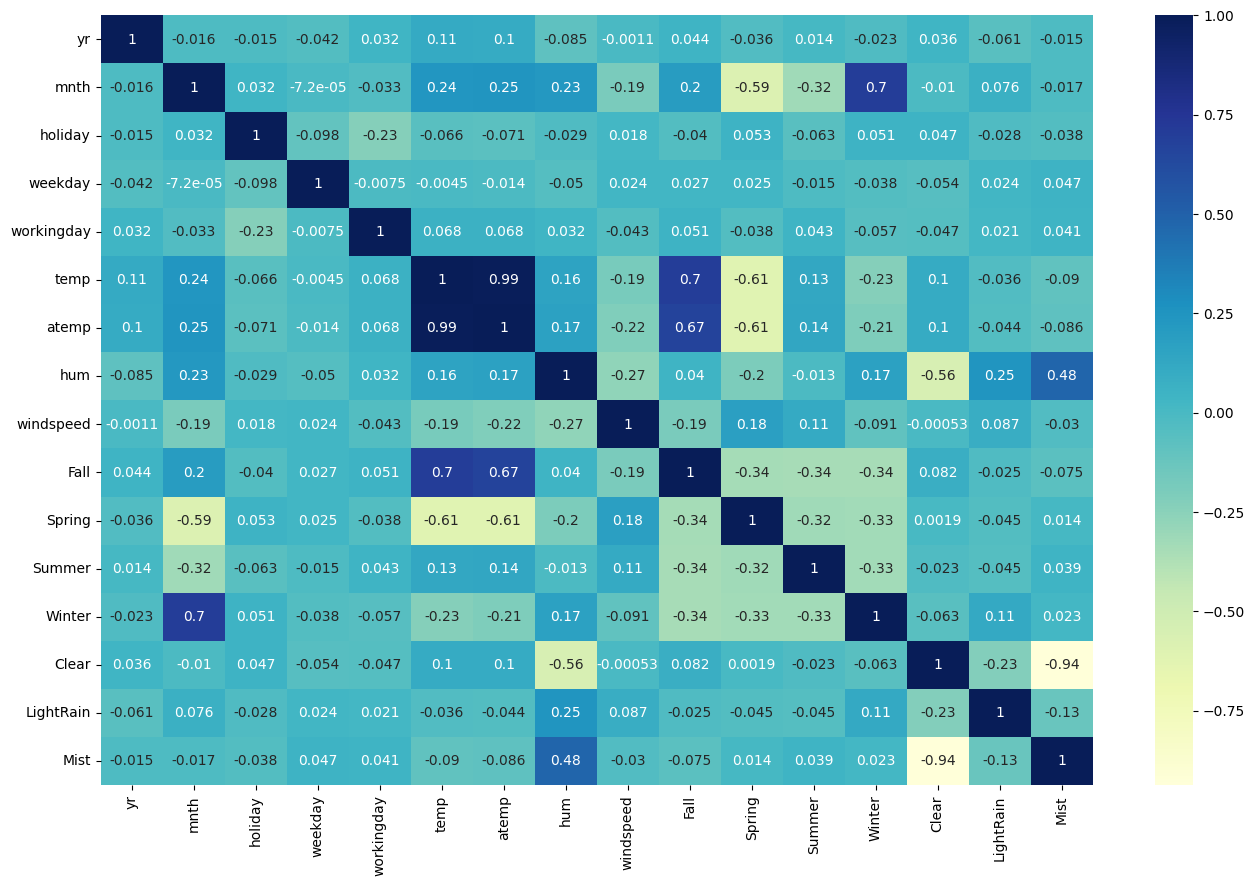

In [45]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(X_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

`temp` and `atemp` are highly correlated, so, we should keep only one of two.
There's a high correlation between `winter` and `month` & `temp` and `fall`. But we'll deal with them later.

In [734]:
### Reset


df = pd.read_csv('day.csv')
mapping_yr = {0: 2018, 1: 2019}
df.yr = df.yr.map(mapping_yr)
mapping_weathersit = {1: 'Clear', 2: 'Mist', 3: 'LightRain', 4: 'HeavyRain'}
mapping_season = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}

df.weathersit = df.weathersit.map(mapping_weathersit)
df.season = df.season.map(mapping_season)
df = df.drop(['dteday', 'casual', 'registered', 'instant'], axis=1)
season = pd.get_dummies(df['season'], dtype='int')
weathersit = pd.get_dummies(df['weathersit'], dtype='int')
df = pd.concat([df, season, weathersit], axis = 1)
df = df.drop(columns=['season', 'weathersit'])
y = df.cnt
X = df
X.pop('cnt')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

scaler = MinMaxScaler()
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables

num_vars = ['yr', 'mnth', 'holiday', 'weekday', 'workingday','temp', 'atemp', 'hum', 'windspeed', 'Fall', 'Spring', 'Summer', 'Winter', 'Clear', 'LightRain', 'Mist']

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [735]:
X_train = X_train.drop(columns=['atemp'])
calculate_vif(X_train)

C:\Users\deshmk1\AppData\Roaming\Python\Python310\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
14,Mist,inf
12,Clear,inf
13,LightRain,inf
11,Winter,inf
10,Summer,inf
9,Spring,inf
8,Fall,inf
1,mnth,3.91
5,temp,3.51
6,hum,1.90


The vifs for other predictors seems to have dropped, however we have infinity values for weather and season related features. Going back to correlation heatmap, it seems that there's a high negative correlation between `Clear` and `Mist`. Let's try removing `Mist`.

In [736]:
X_train = X_train.drop(columns=['Mist'])
calculate_vif(X_train)

,Features,VIF
8,Fall,27.55
11,Winter,25.27
10,Summer,20.97
9,Spring,17.39
1,mnth,3.91
5,temp,3.51
6,hum,1.90
12,Clear,1.64
7,windspeed,1.20
13,LightRain,1.12


Removing `Mist` solved the infinite values problem for VIFs of season variables. However, VIF for the season variables is still high. It suggests that there's a multicolinearity. Winter and mnth have a high correlation. Let's remove `Winter`.

In [737]:
X_train = X_train.drop(columns=['Winter'])
calculate_vif(X_train)

,Features,VIF
5,temp,22.94
6,hum,21.56
1,mnth,10.97
8,Fall,5.06
9,Spring,4.96
7,windspeed,4.66
10,Summer,4.61
11,Clear,3.39
4,workingday,3.21
3,weekday,3.17


Removing Winter lowered VIFs of other season columns. However, we still have high VIF for mnth So, let's drop mnth.

In [738]:
X_train = X_train.drop(columns=['mnth'])
calculate_vif(X_train)

,Features,VIF
4,temp,22.59
5,hum,13.16
6,windspeed,4.39
7,Fall,4.36
3,workingday,3.19
2,weekday,3.08
10,Clear,2.95
9,Summer,2.41
8,Spring,2.17
0,yr,2.05


Now we have high VIF for temp. temp has a high positive correlation with Fall and high negative correlation with Spring. Let's try removing `Fall`

In [739]:
X_train = X_train.drop(columns=['Fall'])
calculate_vif(X_train)

,Features,VIF
5,hum,11.50
4,temp,10.57
6,windspeed,4.37
3,workingday,3.19
2,weekday,3.07
9,Clear,2.88
7,Spring,2.16
0,yr,2.04
8,Summer,1.54
10,LightRain,1.14


### Train the model

In [740]:
def buildLinearRegModel(X, Y):
    X_sm = sm.add_constant(X)
    lr = sm.OLS(Y, X_sm).fit()
    return lr

In [741]:
lr1 = buildLinearRegModel(X_train, y_train)
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     211.7
Date:                Wed, 25 Dec 2024   Prob (F-statistic):          9.30e-180
Time:                        15:54:35   Log-Likelihood:                -4144.6
No. Observations:                 510   AIC:                             8313.
Df Residuals:                     498   BIC:                             8364.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2443.9193    328.085      7.449      0.0

Notice that the p-value for Summer (0.632) is way greater than 0.05. So, let's drop `Summer`.

In [743]:
X_train = X_train.drop(columns=['Summer'])
calculate_vif(X_train)

,Features,VIF
5,hum,11.35
4,temp,10.55
6,windspeed,4.10
3,workingday,3.18
2,weekday,3.07
8,Clear,2.88
0,yr,2.04
7,Spring,1.94
9,LightRain,1.13
1,holiday,1.10


Re-train the model

In [744]:
lr2 = buildLinearRegModel(X_train, y_train)
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     233.2
Date:                Wed, 25 Dec 2024   Prob (F-statistic):          6.65e-181
Time:                        15:56:47   Log-Likelihood:                -4144.7
No. Observations:                 510   AIC:                             8311.
Df Residuals:                     499   BIC:                             8358.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2423.9236    325.169      7.454      0.0

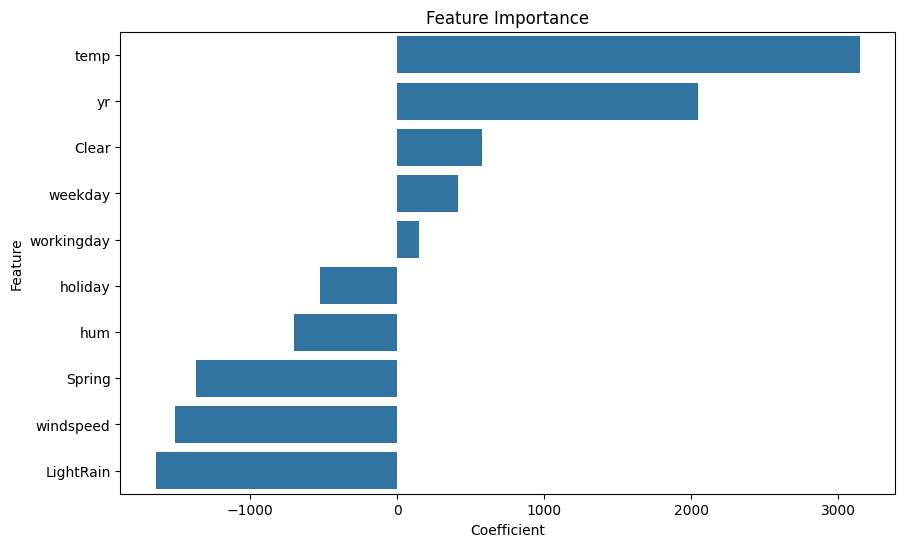

In [746]:
# Plotting the coefficients

coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr2.params[1:]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.show()

## Evaluate the model

1. Residual analysis of the train data
3. Use X_test to predict the `cnt`.
4. Check R squared value

### Residual analysis

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [748]:
X_train_sm = sm.add_constant(X_train)
y_train_pred = lr2.predict(X_train_sm)

In [749]:
# Calculate residuals
residuals = y_train - y_train_pred

# Compute the mean of the residuals
residual_mean = np.mean(residuals)
print(f'Mean of Residuals: {residual_mean}')

Mean of Residuals: -1.7833229446528004e-13


Text(0.5, 0, 'Errors')

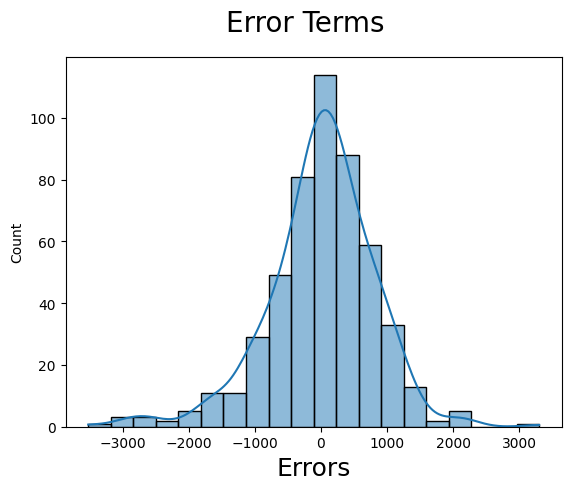

In [750]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.histplot((y_train - y_train_pred), bins = 20, kde=True)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Text(0, 0.5, 'y_train_pred')

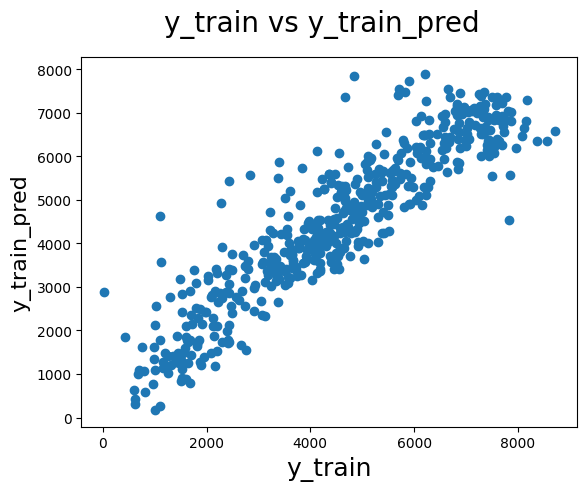

In [751]:
# Let's now plot the graph for actual versus predicted values.

fig = plt.figure()
plt.scatter(y_train, y_train_pred)
fig.suptitle('y_train vs y_train_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_train', fontsize = 18)                          # X-label
plt.ylabel('y_train_pred', fontsize = 16)      

### Making Predictions on the test data using the model

Use X_test to predict y_test using the model lr

In [752]:
print(X_test.shape)
print(X_train.shape)

(219, 16)
(510, 10)


Drop unnecessary columns from X_test

In [753]:
X_test.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'Fall', 'Spring', 'Summer', 'Winter', 'Clear',
       'LightRain', 'Mist'],
      dtype='object')

In [754]:
X_train.columns

Index(['yr', 'holiday', 'weekday', 'workingday', 'temp', 'hum', 'windspeed',
       'Spring', 'Clear', 'LightRain'],
      dtype='object')

In [755]:

num_vars = ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'Fall', 'Spring', 'Summer', 'Winter', 'Clear',
       'LightRain', 'Mist']
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [756]:
X_test.drop(columns=['Mist', 'atemp', 'Winter', 'mnth', 'Fall', 'Summer'], axis=1, inplace=True)

In [757]:
X_test.head()

,yr,holiday,weekday,workingday,temp,hum,windspeed,Spring,Clear,LightRain
184,0.0,1.0,0.166667,0.0,0.831783,0.657364,0.084219,0.0,0.0,0.0
535,1.0,0.0,0.500000,1.0,0.901354,0.610133,0.153728,0.0,1.0,0.0
299,0.0,0.0,0.666667,1.0,0.511964,0.837699,0.334206,0.0,0.0,0.0
221,0.0,0.0,0.500000,1.0,0.881625,0.437098,0.339570,0.0,1.0,0.0
152,0.0,0.0,0.666667,1.0,0.817246,0.314298,0.537414,0.0,1.0,0.0


In [758]:
X_test.shape

(219, 10)

In [759]:
# Making predictions using the lr model
X_test_sm = sm.add_constant(X_test)
y_test_pred = lr2.predict(X_test_sm)

In [760]:
# Calculate residuals
residuals = y_test - y_test_pred

# Compute the mean of the residuals
residual_mean = np.mean(residuals)
print(f'Mean of Residuals: {residual_mean}')

Mean of Residuals: 30.734214401372842


Text(0, 0.5, 'y_pred')

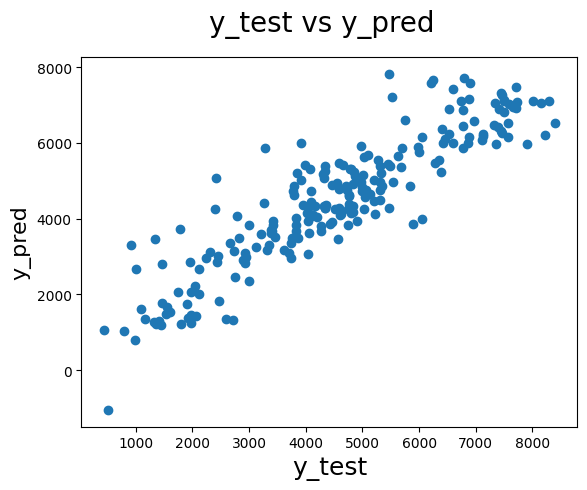

In [761]:
# Let's now plot the graph for actual versus predicted values.

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

In [762]:
# Check the r2 score
print('R squared of the test data using the linear regression model is: ', r2_score(y_test, y_test_pred))

R squared of the test data using the linear regression model is:  0.8061668849521357


## Conclusion

We built a linear regression model `lr2` to predict the bike sharing count. This model produced an R squared value of 0.807 for the test data set.

In [764]:
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     233.2
Date:                Wed, 25 Dec 2024   Prob (F-statistic):          6.65e-181
Time:                        15:58:14   Log-Likelihood:                -4144.7
No. Observations:                 510   AIC:                             8311.
Df Residuals:                     499   BIC:                             8358.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2423.9236    325.169      7.454      0.0

We can see that the equation of our best fitted line is:  

`cnt = 2045.3276 * yr - 526.4530 * holiday + 412.6773 * weekday + 149.6509 * workingday + 3146.4840 * temp - 699.2194 * hum - 1512.3324 * windspeed - 1367.3025 * Spring + 574.3577 * Clear - 1642.0133 * LightRain + 2423.9236`

**R-squared of the model: 0.824**  
**R-squared of the test data: 0.806**